In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
from sympy import Max

from epymorph.kit import * 
from epymorph.adrio import acs5
from epymorph.data.mm.centroids import Centroids
from epymorph.adrio import us_tiger

In [ ]:
class CalvettiSEIR(CompartmentModel): 
    '''Defines the SEIR model used in Calvetti's paper'''

    compartments = [
        compartment('S'), 
        compartment('E'), 
        compartment('I'), 
        compartment('R'), 
        compartment('D')
    ]

    requirements = [
        AttributeDef('beta',type = float, shape = Shapes.TxN),
        AttributeDef('eta',type = float, shape = Shapes.TxN),
        AttributeDef('gamma',type = float, shape = Shapes.TxN),
        AttributeDef('q',type = float, shape = Shapes.TxN),
        AttributeDef('mu',type = float, shape = Shapes.TxN),
    ]

    def edges(self,symbols): 
        [S,E,I,R,D] = symbols.all_compartments
        [β, η ,γ, q,μ] = symbols.all_requirements

        N = Max(1,S+E+I+R)

        return[
            edge(S,E,rate = (β* (E + q*I) * S)/N),
            edge(E,I,rate = (η * E)),
            edge(E,R,rate = (γ * E)),
            edge(I,D,rate = μ * I),
            edge(I,R,rate = γ * I),

        ]

In [ ]:
class CVBeta(ParamFunctionTimeAndNode):

    def evaluate1(self, day: int, node_index: int) -> float:
        T = 100
        beta0 = 0.4
        betainf = 0.1
        tau = 30
        if(day < T):
            return beta0

        return betainf + (beta0 - betainf) * np.exp(-(day - T)/tau)

In [ ]:
scope = CountyScope.in_counties(['Pierce, WA','King, WA','Snohomish, WA','Whatcom, WA','Spokane, WA'], year=2020)

my_ipm = CalvettiSEIR()
mm = mm.Centroids()

rume = SingleStrataRUME.build(
    ipm=my_ipm,
    mm=mm,
    init=init.SingleLocation(location=0,initial_compartment=0,infection_compartment=1,seed_size=100),
    scope=scope,
    time_frame=TimeFrame.of("2015-01-01", 365),
    params={
        'beta': CVBeta(),
        'gamma': 1/14,
        'eta': 1 / 7,
        'q': 0.1,
        'mu': 0.01,
        'population': acs5.Population(),
        'centroid': us_tiger.InternalPoint(),
        'phi':30.0
        
    }
)

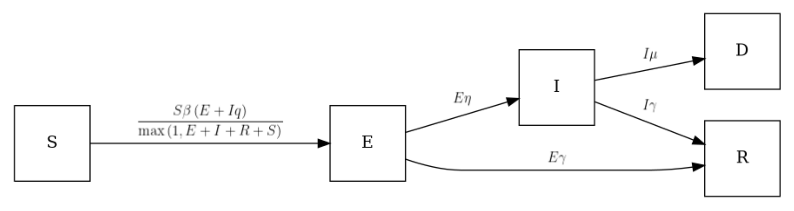

In [ ]:
rume.ipm.diagram()

In [ ]:
sim = BasicSimulator(rume)
with sim_messaging(live = True):
    out = sim.run(
        rng_factory=default_rng(5),
    )


Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.753s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-12-31 (365 days)
• 5 geo nodes
  |####################| 100%                     
Runtime: 0.480s


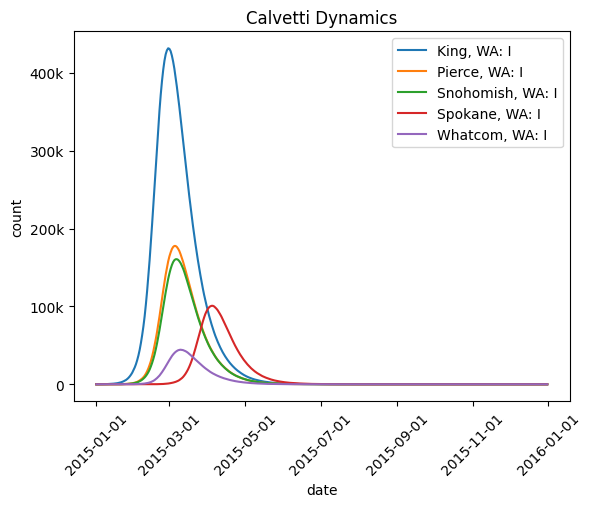

In [ ]:

out.plot.line(
    geo=out.rume.scope.select.all(),
    time=out.rume.time_frame.select.all().group("day").agg(),
    quantity=out.rume.ipm.select.compartments("I"),
    title="Calvetti Dynamics", 
    legend="on"
)